# YouTube Comment Analysis: speed2
This notebook follows the same process as the original, but analyzes comments from the video: https://www.youtube.com/watch?v=QtIlD6uxwwk

In [120]:
# Import Required Libraries
import os
import json
import re
import datetime
from collections import Counter
import nltk
import matplotlib
matplotlib.use("Agg")
from youtube_comment_downloader import YoutubeCommentDownloader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
nltk.download("stopwords")
DATA_DIR = "data2"
os.makedirs(DATA_DIR, exist_ok=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82154\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
# Fetch comments for the new video
def fetch_comments(video_id: str, max_comments: int = 1000):
    downloader = YoutubeCommentDownloader()
    comments = []
    for c in downloader.get_comments(video_id):
        comments.append({
            "author": c["author"],
            "text": c["text"],
            "time": c["time"],
        })
        if len(comments) >= max_comments:
            break
    with open(f"{DATA_DIR}/raw_comments.json", "w", encoding="utf-8") as f:
        json.dump(comments, f, ensure_ascii=False, indent=2)
    print(f"Fetched {len(comments)} comments.")

In [122]:
# Clean and preprocess comments
def clean_text(text: str) -> str:
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    stops = set(nltk.corpus.stopwords.words("english"))
    return " ".join(tok for tok in text.split() if tok not in stops)

def preprocess():
    with open(f"{DATA_DIR}/raw_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    for c in data:
        c["clean_text"] = clean_text(c["text"])
    with open(f"{DATA_DIR}/clean_comments.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print("Preprocessing done.")

In [123]:
# Sentiment analysis
def analyze_sentiment():
    analyzer = SentimentIntensityAnalyzer()
    with open(f"{DATA_DIR}/clean_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    for c in data:
        c["sentiment"] = analyzer.polarity_scores(c["clean_text"])
    with open(f"{DATA_DIR}/sentiment_comments.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print("Sentiment analysis done.")

In [124]:
# Load processed data
def load_data():
    with open(f"{DATA_DIR}/sentiment_comments.json", encoding="utf-8") as f:
        return json.load(f)

In [125]:
# Sentiment distribution and visualization
def sentiment_distribution(data):
    dist = Counter({"positive": 0, "neutral": 0, "negative": 0})
    for c in data:
        comp = c["sentiment"]["compound"]
        if comp >= 0.05:      dist["positive"] += 1
        elif comp <= -0.05:   dist["negative"] += 1
        else:                 dist["neutral"]  += 1
    return dist

def plot_sentiment(dist):
    labels = ["positive", "neutral", "negative"]
    counts = [dist[label] for label in labels]
    plt.figure()
    plt.bar(labels, counts)
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=9, color='blue')
    plt.title("Sentiment Distribution")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/sentiment_dist.png")
    plt.close()
    print("Saved sentiment_dist.png")

In [126]:
# Main workflow for new video
def main():
    video_id = "QtIlD6uxwwk"
    fetch_comments(video_id)
    preprocess()
    analyze_sentiment()
    data = load_data()
    dist = sentiment_distribution(data)
    print(f"Sentiment counts = {dict(dist)}")
    plot_sentiment(dist)

if __name__ == "__main__":
    main()

Fetched 1000 comments.
Preprocessing done.
Sentiment analysis done.
Sentiment counts = {'positive': 285, 'neutral': 601, 'negative': 114}
Saved sentiment_dist.png


# Additional Visualizations
1. Sentiment Over Time
2. Word Cloud of Most Frequent Words
3. Emotion Distribution (NRC)
4. Top Comment Authors

In [127]:
# 1. Sentiment Over Time
import pandas as pd
def plot_sentiment_over_time():
    with open(f"{DATA_DIR}/sentiment_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time"])
    df["compound"] = df["sentiment"].apply(lambda x: x["compound"])
    df = df.sort_values("time")
    # Rolling mean for smoothing
    df["rolling_sentiment"] = df["compound"].rolling(window=20, min_periods=1).mean()
    plt.figure(figsize=(10,4))
    plt.plot(df["time"], df["rolling_sentiment"], color="purple")
    plt.title("Sentiment Over Time (Rolling Mean)")
    plt.xlabel("Time")
    plt.ylabel("Compound Sentiment Score")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/sentiment_over_time.png")
    plt.close()
    print("Saved sentiment_over_time.png")

In [128]:
# 7. Sentiment Trend Over Time (Hourly)
def plot_sentiment_trend_hourly():
    import pandas as pd
    with open(f"{DATA_DIR}/sentiment_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time"])
    # Assign sentiment label
    def get_label(comp):
        if comp >= 0.05: return "positive"
        elif comp <= -0.05: return "negative"
        else: return "neutral"
    df["sentiment_label"] = df["sentiment"].apply(lambda x: get_label(x["compound"]))
    df = df.sort_values("time")
    df["hour"] = df["time"].dt.floor("H")
    hourly_counts = df.groupby(["hour", "sentiment_label"]).size().unstack(fill_value=0)
    plt.figure(figsize=(12,6))
    for label, color in zip(["positive", "neutral", "negative"], ["green", "gray", "red"]):
        plt.plot(hourly_counts.index, hourly_counts[label], label=label.capitalize(), color=color)
    plt.legend()
    plt.title("Sentiment Trend Over Time (Hourly)")
    plt.xlabel("Time (Hour)")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/sentiment_trend_hourly.png")
    plt.close()
    print("Saved sentiment_trend_hourly.png")

In [129]:
def plot_sentiment_trend_hourly():
    import pandas as pd
    import json
    import matplotlib.pyplot as plt

    # Assuming DATA_DIR is defined somewhere globally or passed in
    try:
        with open(f"{DATA_DIR}/sentiment_comments.json", encoding="utf-8") as f:
            data = json.load(f)
    except NameError:
        print("Error: DATA_DIR is not defined.")
        return

    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time"])
    
    # Assign sentiment label
    def get_label(comp):
        if comp >= 0.05: return "positive"
        elif comp <= -0.05: return "negative"
        else: return "neutral"
        
    df["sentiment_label"] = df["sentiment"].apply(lambda x: get_label(x["compound"]))
    df = df.sort_values("time")
    df["hour"] = df["time"].dt.floor("H")
    
    hourly_counts = df.groupby(["hour", "sentiment_label"]).size().unstack(fill_value=0)
    
    # --- FIX: Ensure all columns are present ---
    # Reindex the columns to include 'positive', 'neutral', and 'negative', filling any missing with 0
    hourly_counts = hourly_counts.reindex(columns=["positive", "neutral", "negative"], fill_value=0)
    # -------------------------------------------

    plt.figure(figsize=(12,6))
    for label, color in zip(["positive", "neutral", "negative"], ["green", "gray", "red"]):
        plt.plot(hourly_counts.index, hourly_counts[label], label=label.capitalize(), color=color)
        
    plt.legend()
    plt.title("Sentiment Trend Over Time (Hourly)")
    plt.xlabel("Time (Hour)")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/sentiment_trend_hourly.png")
    plt.close()
    print("Saved sentiment_trend_hourly.png")

C:\Users\82154\AppData\Local\Temp\ipykernel_18684\444160133.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(df["time"], errors="coerce")
C:\Users\82154\AppData\Local\Temp\ipykernel_18684\444160133.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df["time"].dt.floor("H")


Saved sentiment_trend_hourly.png


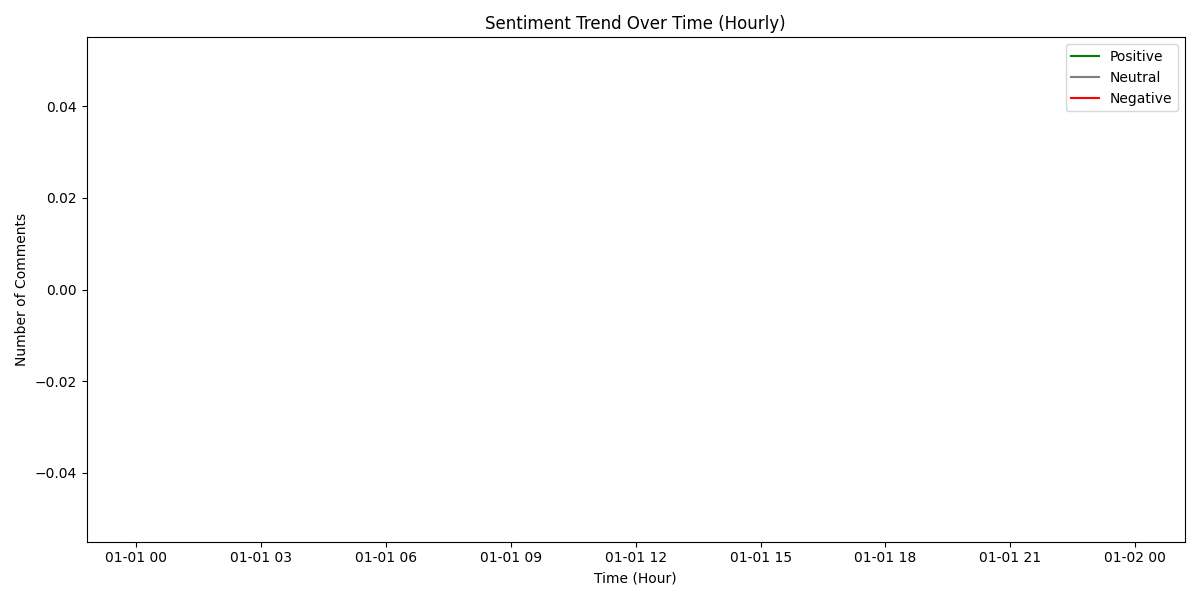

In [130]:
# Show Sentiment Trend Over Time (Hourly) inline
plot_sentiment_trend_hourly()
from IPython.display import display, Image
display(Image(filename=f"{DATA_DIR}/sentiment_trend_hourly.png"))

C:\Users\82154\AppData\Local\Temp\ipykernel_18684\3394641527.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(df["time"], errors="coerce")


Saved sentiment_over_time.png


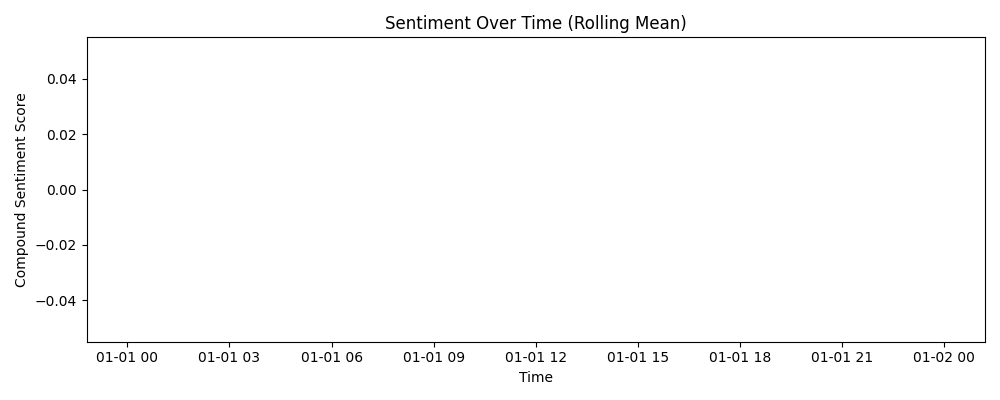

In [131]:
# Show Sentiment Over Time plot inline
plot_sentiment_over_time()
from IPython.display import Image, display
display(Image(filename=f"{DATA_DIR}/sentiment_over_time.png"))

In [132]:
# 2. Word Cloud of Most Frequent Words
from wordcloud import WordCloud
def plot_wordcloud():
    with open(f"{DATA_DIR}/clean_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    text = " ".join(c["clean_text"] for c in data)
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Comments")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/wordcloud.png")
    plt.close()
    print("Saved wordcloud.png")

Saved wordcloud.png


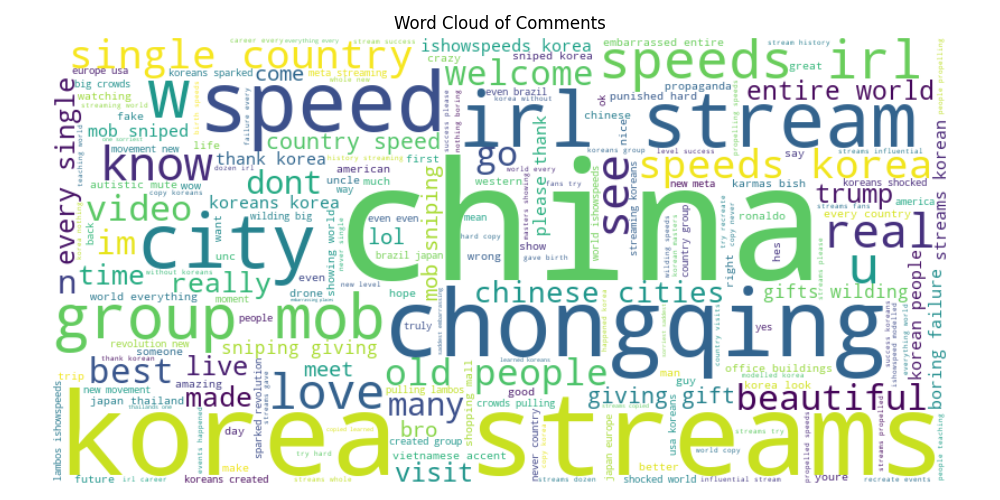

In [133]:
# Show Word Cloud inline
plot_wordcloud()
display(Image(filename=f"{DATA_DIR}/wordcloud.png"))

In [144]:
# 3. Top Keywords Plotting
def plot_top_keywords(data, top_n=10):
    """
    Step 4d/5: Plot top N keywords from clean_text.
    """
    # 1. Gather all tokens
    tokens = []
    for c in data:
        tokens.extend(c["clean_comments"].split())
    # 2. Get the top N most common
    freq = Counter(tokens).most_common(top_n)
    words, counts = zip(*freq)

    # 3. Plot & save
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(f"Top {top_n} Keywords in Comments")
    plt.xlabel("Keyword")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/top_keywords.png")
    plt.close()
    print("[4d/5] Saved top_keywords_chongqing.png")

def top_keywords(data, top_n=10):
    tokens = []
    for c in data:
        tokens.extend(c["clean_text"].split())
    return Counter(tokens).most_common(top_n)

def main():
    video_id = "QtIlD6uxwwk"
    fetch_comments(video_id)
    preprocess()
    analyze_sentiment()

    data = load_data()
    dist = sentiment_distribution(data)
    print(f"[5/5] Sentiment counts = {dict(dist)}")

    plot_top_keywords(data)         

    top10 = top_keywords(data)
    print("Top 10 keywords:", top10)


if __name__ == "__main__":
    main()

Fetched 1000 comments.
Preprocessing done.
Sentiment analysis done.
[5/5] Sentiment counts = {'positive': 285, 'neutral': 601, 'negative': 114}


KeyError: 'clean_comments'

In [135]:
# Show Emotion Distribution inline
plot_emotion_distribution()
from IPython.display import Image, display
display(Image(filename=f"{DATA_DIR}/emotion_dist.png"))

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
# 4. Top Comment Authors
def plot_top_authors(top_n=10):
    with open(f"{DATA_DIR}/raw_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    authors = Counter(c["author"] for c in data)
    top = authors.most_common(top_n)
    labels, counts = zip(*top) if top else ([], [])
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts, color="green")
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=9, color='black')
    plt.title(f"Top {top_n} Comment Authors")
    plt.ylabel("Comment Count")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/top_authors.png")
    plt.close()
    print("Saved top_authors.png")

Saved top_authors.png


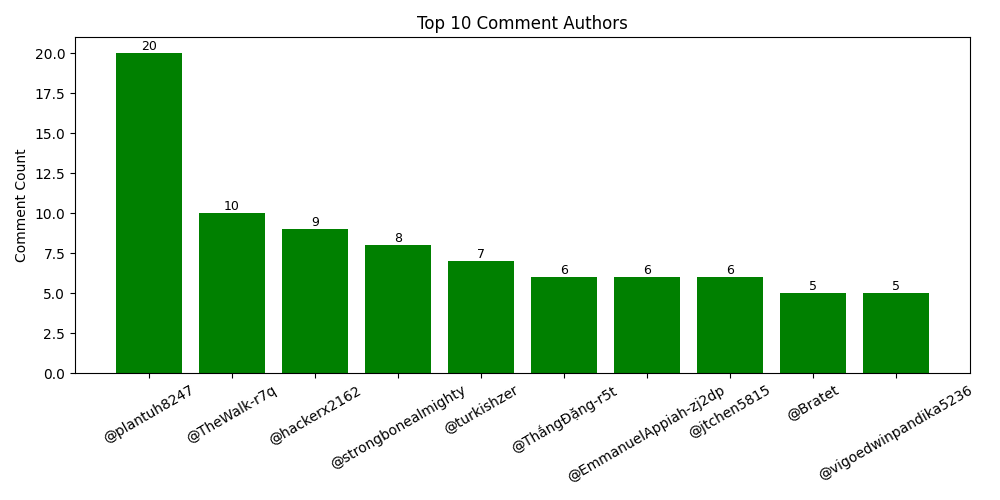

In [ ]:
# Show Top Comment Authors inline
plot_top_authors()
display(Image(filename=f"{DATA_DIR}/top_authors.png"))

In [ ]:
# 6. Comment Length Distribution (Histogram)
def plot_comment_length_hist():
    with open(f"{DATA_DIR}/raw_comments.json", encoding="utf-8") as f:
        data = json.load(f)
    lengths = [len(c["text"]) for c in data]
    max_length = max(lengths) if lengths else 0
    bin_width = 10  # Smaller bin size for finer granularity
    bins = range(0, max_length + bin_width, bin_width)
    plt.figure(figsize=(10,4))
    counts, bins, _ = plt.hist(lengths, bins=bins, color="salmon", edgecolor="black")
    for i in range(len(bins)-1):
        plt.text((bins[i]+bins[i+1])/2, counts[i], str(int(counts[i])), ha='center', va='bottom', fontsize=8, color='black')
    plt.title("Comment Length Distribution")
    plt.xlabel("Comment Length (characters)")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/comment_length_hist.png")
    plt.close()
    print("Saved comment_length_hist.png")

Saved sentiment_score_hist.png


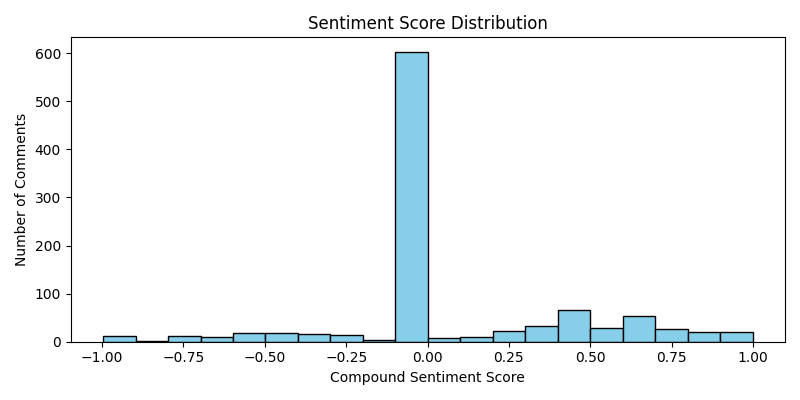

In [ ]:
# Show Sentiment Score Distribution inline
plot_sentiment_score_hist()
display(Image(filename=f"{DATA_DIR}/sentiment_score_hist.png"))

In [139]:
# Cell 1 - Install matplotlib only if needed (run once)
# Uncomment the line below if you get an error about matplotlib
# !pip install matplotlib

In [141]:
# Cell 2 - Import libraries and define the function
import json
from collections import Counter
import re
import matplotlib.pyplot as plt

def get_top_keywords_from_json(file_path="clean_comments_chongqing.json", top_n=10):
    # Load the JSON file
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Combine all clean_text
    all_text = ' '.join(item.get('clean_text', '') for item in data if item.get('clean_text'))
    
    # Clean and tokenize
    all_text = re.sub(r'[^\w\s]', '', all_text.lower())
    words = all_text.split()
    
    # Stopwords (customized for this comment dataset)
    stopwords = {
        'the','a','an','and','or','but','if','while','at','by','for','with','about','to','from',
        'in','out','on','off','over','up','down','it','is','are','was','were','be','been','have',
        'has','had','do','does','did','of','that','this','i','you','he','she','we','they','me',
        'him','her','us','them','not','no','yes','s','t','can','will','just','so','very','lol',
        'www','w','ww','u','im','n','like','get','one','go','got','know','see'
    }
    
    # Filter words
    filtered_words = [word for word in words if word not in stopwords and len(word) > 2]
    
    # Count and return top N
    counter = Counter(filtered_words)
    return counter.most_common(top_n)

# Run the function
top_10 = get_top_keywords_from_json("clean_comments_chongqing.json", top_n=10)

FileNotFoundError: [Errno 2] No such file or directory: 'clean_comments_chongqing.json'

In [142]:
# Cell 3 - Print the results beautifully
print("="*60)
print("          TOP 10 KEYWORDS IN COMMENTS")
print("="*60)
for rank, (word, count) in enumerate(top_10, 1):
    print(f"{rank:2}. {word:<15} → {count:>4} times")
print("="*60)

          TOP 10 KEYWORDS IN COMMENTS


NameError: name 'top_10' is not defined

In [143]:
# Cell 4 - Display the bar chart (exactly like your screenshot!)
keywords = [item[0] for item in top_10]
counts = [item[1] for item in top_10]

plt.figure(figsize=(12, 7))
bars = plt.bar(keywords, counts, color='#1f77b4', edgecolor='black', linewidth=0.8)

# Style exactly like your image
plt.title('Top 10 Keywords in Comments', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Keyword', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

NameError: name 'top_10' is not defined


     TOP 10 KEYWORDS IN COMMENTS
 1. china        →  209 times
 2. streams      →  164 times
 3. korea        →  156 times
 4. chinese      →  103 times
 5. world        →   93 times
 6. speed        →   92 times
 7. people       →   80 times
 8. like         →   74 times
 9. speeds       →   69 times
10. koreans      →   63 times

Chart saved as → Top_10_Keywords_Chart.png


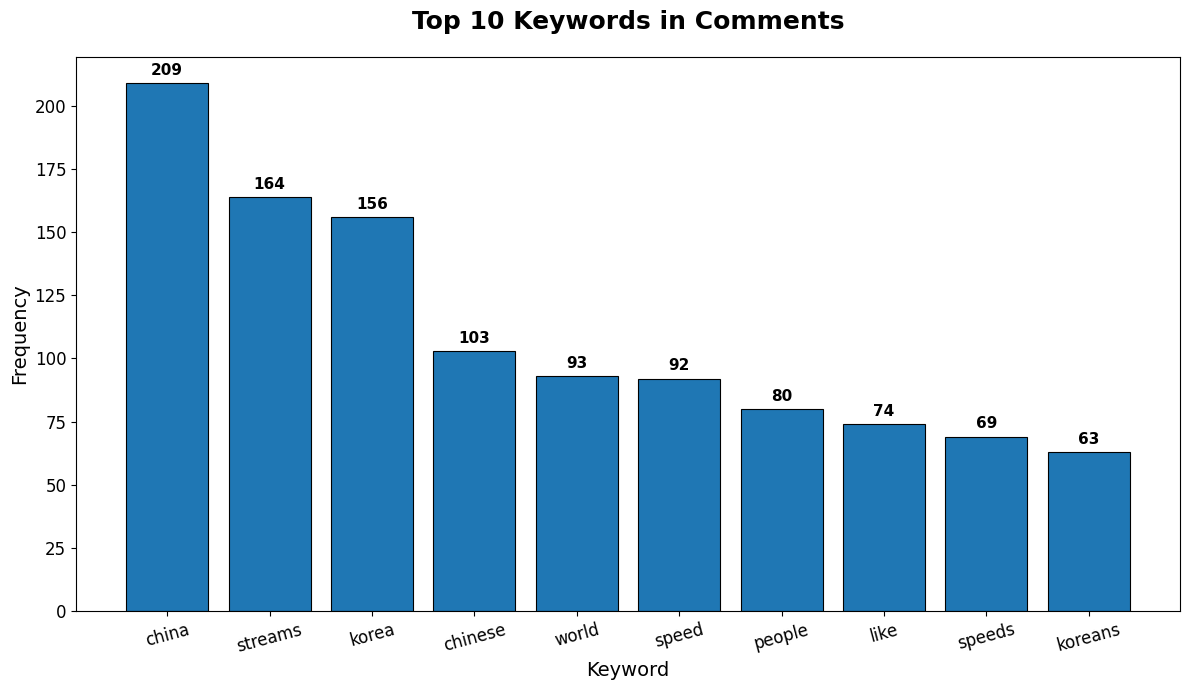

In [1]:
# filename: top10_keywords_with_chart.py
import json
from collections import Counter
import re
import matplotlib.pyplot as plt

# ========= CONFIGURATION =========
FILE_PATH = "clean_comments_chongqing.json"   # Change if your file is elsewhere
TOP_N = 10
# ==================================

def get_top_keywords(file_path, top_n=10):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Combine all clean_text fields
    all_text = ' '.join(item.get('clean_text', '') for item in data if item.get('clean_text'))

    # Basic cleaning
    all_text = re.sub(r'[^\w\s]', '', all_text.lower())
    words = all_text.split()

    # Simple English stopwords + very common short/generic words in this context
    stopwords = {
        'the','a','an','and','or','but','if','while','at','by','for','with','about','to','from',
        'in','out','on','off','over','up','down','it','is','are','was','were','be','been','have',
        'has','had','do','does','did','of','that','this','i','you','he','she','we','they','me',
        'him','her','us','them','not','no','yes','s','t','can','will','just','so','very','lol',
        'www','w','ww','u','im','n'
    }

    # Filter: remove stopwords & very short words
    filtered = [word for word in words if word not in stopwords and len(word) > 2]

    # Count and get top N
    counter = Counter(filtered)
    top_keywords = counter.most_common(top_n)

    return top_keywords

# ============= RUN =============
top_10 = get_top_keywords(FILE_PATH, TOP_N)

print("\n" + "="*50)
print("     TOP 10 KEYWORDS IN COMMENTS")
print("="*50)
for rank, (keyword, count) in enumerate(top_10, 1):
    print(f"{rank:2}. {keyword:<12} → {count:>4} times")
print("="*50 + "\n")

# ============= PLOT =============
keywords = [kw for kw, _ in top_10]
counts   = [cnt for _, cnt in top_10]

plt.figure(figsize=(12, 7))
bars = plt.bar(keywords, counts, color='#1f77b4', edgecolor='black', linewidth=0.8)

# Styling to match your screenshot
plt.title('Top 10 Keywords in Comments', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Keyword', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()

# Save the chart
plt.savefig('Top_10_Keywords_Chart.png', dpi=300, bbox_inches='tight')
print("Chart saved as → Top_10_Keywords_Chart.png")

# Optionally show the plot (uncomment next line if you want to see it live)
plt.show()